In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

In [108]:
df = pd.read_csv("vix_2011_2019.csv")

In [109]:
print(df.head())

         Date       Open       High    Low      Close  Adj Close  Volume
0  2011-02-11  16.530001  16.530001  15.55  15.690000  15.690000       0
1  2011-02-14  16.070000  16.260000  15.22  15.950000  15.950000       0
2  2011-02-15  16.299999  16.750000  16.27  16.370001  16.370001       0
3  2011-02-16  16.309999  16.740000  15.84  16.719999  16.719999       0
4  2011-02-17  17.010000  17.299999  15.88  16.590000  16.590000       0


In [110]:
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 2 columns):
Date         2011 non-null object
Adj Close    2011 non-null float64
dtypes: float64(1), object(1)
memory usage: 31.5+ KB


In [112]:
df['Date'] = pd.to_datetime(df['Date'])

In [113]:
df = df.set_index(['Date'], drop=True)

In [114]:
df.head(10)

,Adj Close
Date,
2011-02-11,15.690000
2011-02-14,15.950000
2011-02-15,16.370001
2011-02-16,16.719999
2011-02-17,16.590000
2011-02-18,16.430000
2011-02-22,20.799999
2011-02-23,22.129999
2011-02-24,21.320000


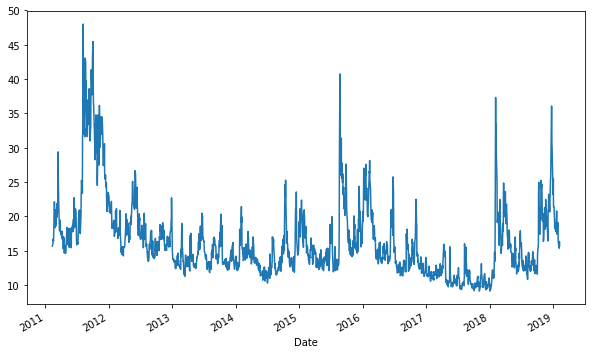

In [115]:
# df = df.sort_index()
plt.figure(figsize=(10, 6))
df['Adj Close'].plot();

In [116]:
split_date = pd.Timestamp('2018-01-01')

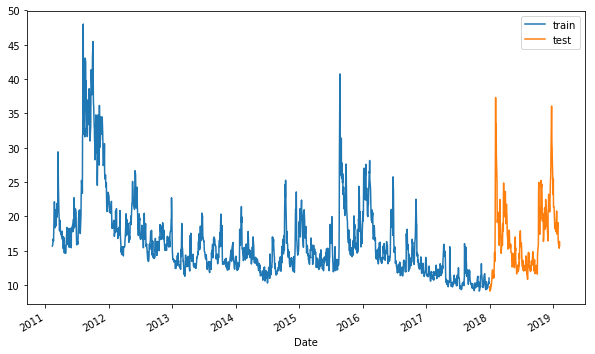

In [117]:
df =  df['Adj Close']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [118]:
# scale train and test data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19.

In [119]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

## NN

In [120]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
1732/1732 [==============================] - 7s 4ms/step - loss: 0.0112
Epoch 2/100
1732/1732 [==============================] - 8s 5ms/step - loss: 0.0063
Epoch 3/100
1732/1732 [==============================] - 8s 5ms/step - loss: 0.0063A: 0s - loss: 0.006
Epoch 4/100
1732/1732 [==============================] - 11s 7ms/step - loss: 0.0063
Epoch 5/100
1732/1732 [==============================] - 8s 5ms/step - loss: 0.0062
Epoch 6/100
1732/1732 [==============================] - 8s 4ms/step - loss: 0.0062
Epoch 7/100
1732/1732 [==============================] - 9s 5ms/step - loss: 0.0061
Epoch 8/100
1732/1732 [==============================] - 8s 5ms/step - loss: 0.0061
Epoch 9/100
1732/1732 [==============================] - 9s 5ms/step - loss: 0.0061
Epoch 10/100
1732/1732 [==============================] - 8s 5ms/step - loss: 0.0061
Epoch 11/100
1732/1732 [==============================] - 9s 5ms/step - loss: 0.0061
Epoch 12/100
1732/1732 [==============================

In [121]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.897
The R2 score on the Test set is:	0.789


## LSTM

In [91]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

In [93]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (1732, 1, 1)
Test shape:  (277, 1, 1)


In [95]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
1732/1732 [==============================] - 54s 31ms/step - loss: 0.0220
Epoch 2/100
1732/1732 [==============================] - 53s 31ms/step - loss: 0.0090
Epoch 3/100
1732/1732 [==============================] - 52s 30ms/step - loss: 0.0063
Epoch 4/100
1732/1732 [==============================] - 50s 29ms/step - loss: 0.0060 0s - l
Epoch 5/100
1732/1732 [==============================] - 51s 29ms/step - loss: 0.0060
Epoch 6/100
1732/1732 [==============================] - 50s 29ms/step - loss: 0.0060
Epoch 7/100
1732/1732 [==============================] - 50s 29ms/step - loss: 0.0060
Epoch 8/100
1732/1732 [==============================] - 50s 29ms/step - loss: 0.0060
Epoch 9/100
1732/1732 [==============================] - 50s 29ms/step - loss: 0.0060
Epoch 10/100
1732/1732 [==============================] - 48s 28ms/step - loss: 0.0060
Epoch 00010: early stopping


In [96]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.914
The R2 score on the Test set is:	0.806


In [98]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

277/277 [==============================] - 0s 2ms/step
NN: 0.013070
LSTM: 0.012428


In [99]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

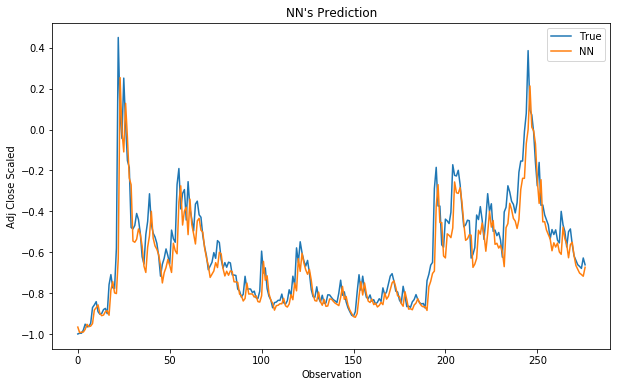

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

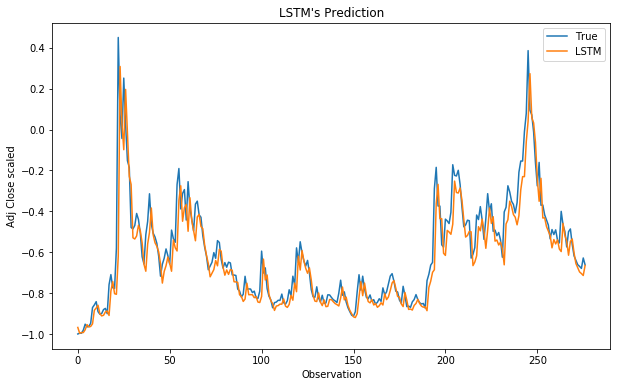

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();